# Using Building Data in RDF & SPARQL 
This notebook was created for the LDAC 2022 summer school it heavily leans on many peoples work. Most importantly, it is following the nice tutorials by Jörg Schad, thank you https://github.com/joerg84 for sharing your code

# Setup Environment

In [56]:
import rdflib
from rdflib import Graph
from rdflib.namespace import DC, RDF, FOAF, RDFS
from rdflib import URIRef, BNode, Literal
import networkx as nx
import io
import pydotplus
from IPython.display import display, Image
from rdflib.tools.rdf2dot import rdf2dot
from pprint import pprint

In [57]:
# Helper function for vizualizing RDF graph
def visualize(g):
    stream = io.StringIO()
    rdf2dot(g, stream, opts = {display})
    dg = pydotplus.graph_from_dot_data(stream.getvalue())
    png = dg.create_png()
    display(Image(png)) 

# A simple building graph

In [58]:
g = Graph()


# Graph using TURTLE syntax
turtle = """
@prefix : <http://www.ldac.org/ns/building1#> .
@prefix xsd: <http://www.w3.org/2001/XMLSchema#> . 

:Building :hasStorey :GroundFloor .
:GroundFloor :hasElement :Wall1 ;
      :height    "3.5"^^xsd:float .
      
      
:Wall1 :hasMaterial :Brick ;
      :isExternal    "false"^^xsd:boolean ;
      :hasOpening :Window1 .
:Window1 :hasMaterial :Wood ;
      :hasHost    :Wall1 .

"""
g.parse(data=turtle, format="turtle")

<Graph identifier=N41845236e3384da585a35893806492e8 (<class 'rdflib.graph.Graph'>)>

Let us print all tripes:

In [59]:
#print all triples
for s, p, o in g:
   pprint((s, p, o))

(rdflib.term.URIRef('http://www.ldac.org/ns/building1#Wall1'),
 rdflib.term.URIRef('http://www.ldac.org/ns/building1#isExternal'),
 rdflib.term.Literal('false', datatype=rdflib.term.URIRef('http://www.w3.org/2001/XMLSchema#boolean')))
(rdflib.term.URIRef('http://www.ldac.org/ns/building1#GroundFloor'),
 rdflib.term.URIRef('http://www.ldac.org/ns/building1#height'),
 rdflib.term.Literal('3.5', datatype=rdflib.term.URIRef('http://www.w3.org/2001/XMLSchema#float')))
(rdflib.term.URIRef('http://www.ldac.org/ns/building1#Wall1'),
 rdflib.term.URIRef('http://www.ldac.org/ns/building1#hasOpening'),
 rdflib.term.URIRef('http://www.ldac.org/ns/building1#Window1'))
(rdflib.term.URIRef('http://www.ldac.org/ns/building1#Window1'),
 rdflib.term.URIRef('http://www.ldac.org/ns/building1#hasHost'),
 rdflib.term.URIRef('http://www.ldac.org/ns/building1#Wall1'))
(rdflib.term.URIRef('http://www.ldac.org/ns/building1#Window1'),
 rdflib.term.URIRef('http://www.ldac.org/ns/building1#hasMaterial'),
 rdflib.t

As this is hard to read, let us visualize the RDF graph:

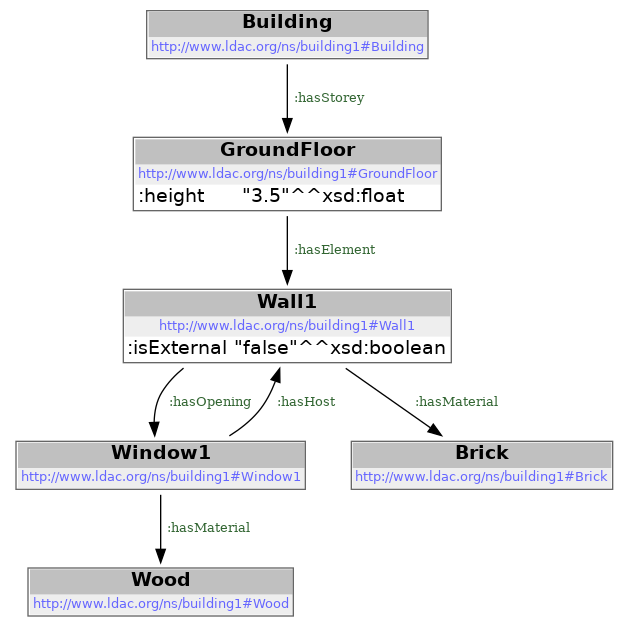

In [60]:
visualize(g)



Let's get everying we know about wall 1:

In [61]:
from pprint import pprint
# Lookup Jane by global identifier
wall1 = URIRef('http://www.ldac.org/ns/building1#Wall1')
pprint([o for o in g.predicate_objects(subject=wall1)])

[(rdflib.term.URIRef('http://www.ldac.org/ns/building1#hasMaterial'),
  rdflib.term.URIRef('http://www.ldac.org/ns/building1#Brick')),
 (rdflib.term.URIRef('http://www.ldac.org/ns/building1#isExternal'),
  rdflib.term.Literal('false', datatype=rdflib.term.URIRef('http://www.w3.org/2001/XMLSchema#boolean'))),
 (rdflib.term.URIRef('http://www.ldac.org/ns/building1#hasOpening'),
  rdflib.term.URIRef('http://www.ldac.org/ns/building1#Window1'))]


# Custom Graph

Instead of providing files serialized in long strings, let's create a graph explicitly. This means constructing exlicit nodes and edges (predicates). 

Nodes can have different on of three types:
- URI, 
- B(lank)Node, or 
- Literals.

We will recreate the BOT example 5 from the [documentation](https://w3c-lbd-cg.github.io/bot/#example-5) 

![grafik.png](data/bot-image-doc.png)


In [110]:
from rdflib import Namespace
bot = Namespace ("https://w3id.org/bot#")
ldac = Namespace ("https://ldac.org/building2/")
g = Graph()
g.bind("bot", bot, False)
g.bind("ldac", ldac, False)

(rdflib.term.URIRef('https://ldac.org/building2/SiteA'),
 rdflib.term.URIRef('http://www.w3.org/1999/02/22-rdf-syntax-ns#type'),
 rdflib.term.URIRef('https://w3id.org/bot#Site'))
(rdflib.term.URIRef('https://ldac.org/building2/Storey01'),
 rdflib.term.URIRef('https://w3id.org/bot#hasSpace'),
 rdflib.term.URIRef('https://ldac.org/building2/SpaceC'))
(rdflib.term.URIRef('https://ldac.org/building2/Storey00'),
 rdflib.term.URIRef('https://w3id.org/bot#hasSpace'),
 rdflib.term.URIRef('https://ldac.org/building2/SpaceA'))
(rdflib.term.URIRef('https://ldac.org/building2/Storey00'),
 rdflib.term.URIRef('https://w3id.org/bot#hasSpace'),
 rdflib.term.URIRef('https://ldac.org/building2/SpaceB'))
(rdflib.term.URIRef('https://ldac.org/building2/SpaceA'),
 rdflib.term.URIRef('http://www.w3.org/1999/02/22-rdf-syntax-ns#type'),
 rdflib.term.URIRef('https://w3id.org/bot#Space'))
(rdflib.term.URIRef('https://ldac.org/building2/Storey01'),
 rdflib.term.URIRef('https://w3id.org/bot#hasSpace'),
 rdflib.te

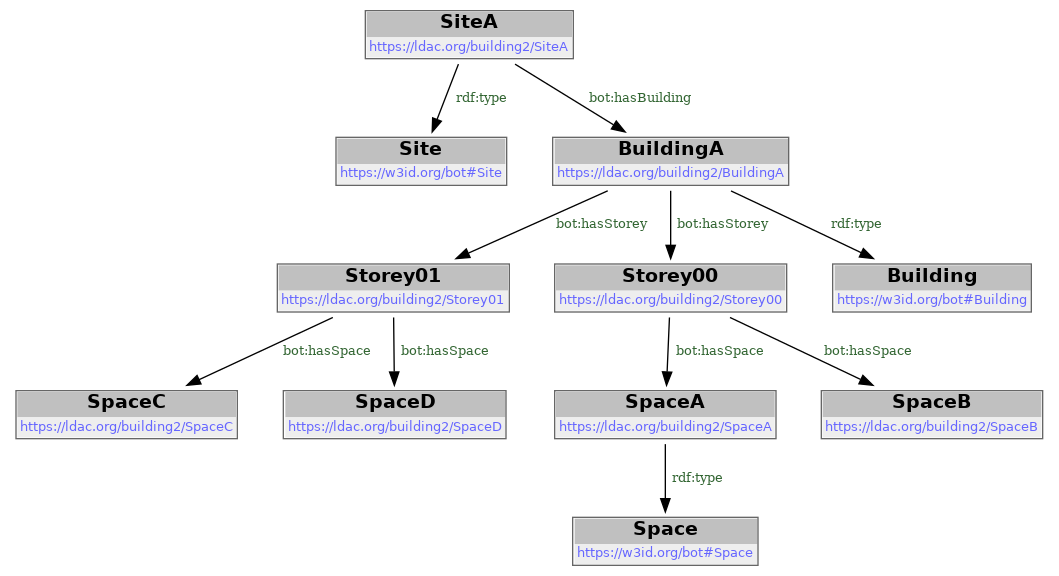

In [111]:
SiteA = URIRef("https://ldac.org/building2/SiteA")

BuildingA = URIRef("https://ldac.org/building2/BuildingA")
Storey00 = URIRef("https://ldac.org/building2/Storey00")
Storey01 = URIRef("https://ldac.org/building2/Storey01")

SpaceA = URIRef("https://ldac.org/building2/SpaceA")
SpaceB = URIRef("https://ldac.org/building2/SpaceB")
SpaceC = URIRef("https://ldac.org/building2/SpaceC")
SpaceD = URIRef("https://ldac.org/building2/SpaceD")

Storey01 = URIRef("https://ldac.org/building2/Storey01")



g.add( (SiteA, RDF.type, bot.Site) )
g.add( (SiteA, bot.hasBuilding, BuildingA) )
g.add( (BuildingA, bot.hasStorey, Storey00) )
g.add( (BuildingA, bot.hasStorey, Storey01) )

g.add( (BuildingA, RDF.type, bot.Building) )
g.add( (Storey00, bot.hasSpace, SpaceA) )
g.add( (Storey00, bot.hasSpace, SpaceB) )


g.add( (Storey01, bot.hasSpace, SpaceC) )
g.add( (Storey01, bot.hasSpace, SpaceD) )

g.add( (SpaceA, RDF.type, bot.Space) )
#g.add( (SpaceB, RDF.type, bot.Space) )
#g.add( (SpaceC, RDF.type, bot.Space) )
#g.add( (SpaceD, RDF.type, bot.Space) )

#print all triples
for s, p, o in g:
   pprint((s, p, o))

# Visualize the graph for easy interpretation
visualize(g)

In [112]:
g.serialize("mini_bot.ttl")

<Graph identifier=N3561d44fb0ee43b8b72d8735d3f097d9 (<class 'rdflib.graph.Graph'>)>

# Query the BOT graph with SPARQL

## List all facts (s,p,o triples)

In [113]:

result = g.query(
    """SELECT *
  WHERE
  {?s ?p ?o}
  LIMIT 10
""")

# Output result
for row in result:
    pprint(row)


(rdflib.term.URIRef('https://w3id.org/bot#Site'),
 rdflib.term.URIRef('http://www.w3.org/1999/02/22-rdf-syntax-ns#type'),
 rdflib.term.URIRef('https://ldac.org/building2/SiteA'))
(rdflib.term.URIRef('https://ldac.org/building2/SpaceC'),
 rdflib.term.URIRef('https://w3id.org/bot#hasSpace'),
 rdflib.term.URIRef('https://ldac.org/building2/Storey01'))
(rdflib.term.URIRef('https://ldac.org/building2/SpaceA'),
 rdflib.term.URIRef('https://w3id.org/bot#hasSpace'),
 rdflib.term.URIRef('https://ldac.org/building2/Storey00'))
(rdflib.term.URIRef('https://ldac.org/building2/SpaceB'),
 rdflib.term.URIRef('https://w3id.org/bot#hasSpace'),
 rdflib.term.URIRef('https://ldac.org/building2/Storey00'))
(rdflib.term.URIRef('https://w3id.org/bot#Space'),
 rdflib.term.URIRef('http://www.w3.org/1999/02/22-rdf-syntax-ns#type'),
 rdflib.term.URIRef('https://ldac.org/building2/SpaceA'))
(rdflib.term.URIRef('https://ldac.org/building2/SpaceD'),
 rdflib.term.URIRef('https://w3id.org/bot#hasSpace'),
 rdflib.term

## Retrieve dedicated relations
We can leverage URIs, variables, and predicates to specify pattern we are looking for. 

In this case we want to retreive the spaces associated to the storeys.

Note how we are making the BOT namespace available by the `initNS` statement

In [119]:
result = g.query(
    """SELECT DISTINCT ?a ?b
       WHERE {
          ?a bot:hasSpace ?b .
          
       }""",  initNs={ 'bot': bot })

# Output result
for row in result:
    print("%s has Space %s" % row)

https://ldac.org/building2/Storey00 has Space https://ldac.org/building2/SpaceA
https://ldac.org/building2/Storey00 has Space https://ldac.org/building2/SpaceB
https://ldac.org/building2/Storey01 has Space https://ldac.org/building2/SpaceC
https://ldac.org/building2/Storey01 has Space https://ldac.org/building2/SpaceD


# Import external Data

There are a large number of RDF data sources available on the web, which we can leverage:

In [67]:
from rdflib import Namespace
bot = Namespace ("https://w3id.org/bot#")
duplex = Namespace ("https://ldac.org/duplex/")

g1 = rdflib.Graph()
g1.parse("http://www.w3.org/People/Berners-Lee/card")

print("Graph has %s statements." % len(g1))

# print all tuples
for s, p, o in g1:
   print((s, p, o))

Graph has 86 statements.
(rdflib.term.URIRef('http://www.w3.org/People/Berners-Lee/card'), rdflib.term.URIRef('http://xmlns.com/foaf/0.1/maker'), rdflib.term.URIRef('https://www.w3.org/People/Berners-Lee/card#i'))
(rdflib.term.BNode('Nf2244a0c7e4747e8837c73edadd652b5'), rdflib.term.URIRef('http://www.w3.org/2006/vcard/ns#street-address'), rdflib.term.Literal('32 Vassar Street'))
(rdflib.term.URIRef('https://timbl.com/timbl/Public/friends.ttl'), rdflib.term.URIRef('http://www.w3.org/1999/02/22-rdf-syntax-ns#type'), rdflib.term.URIRef('http://xmlns.com/foaf/0.1/PersonalProfileDocument'))
(rdflib.term.URIRef('https://www.w3.org/People/Berners-Lee/card#i'), rdflib.term.URIRef('http://xmlns.com/foaf/0.1/nick'), rdflib.term.Literal('timbl'))
(rdflib.term.URIRef('https://www.w3.org/People/Berners-Lee/card#i'), rdflib.term.URIRef('http://xmlns.com/foaf/0.1/account'), rdflib.term.URIRef('http://twitter.com/timberners_lee'))
(rdflib.term.URIRef('http://www.ecs.soton.ac.uk/~dt2/dlstuff/www2006_da

# Turn IFC spaces in to a BOT Graph

In [68]:
import ifcopenshell
model = ifcopenshell.open("data/Duplex_A.ifc")

Let us look at what we are dealing with. Only execute the cell below if you have about 1 min time to wait for the rendering

In [69]:
from utils.JupyterIFCRenderer import JupyterIFCRenderer
viewer = JupyterIFCRenderer(model, size=(400,300))
viewer

In [88]:
dg = Graph() #our duplex-graph
from rdflib import Namespace
bot = Namespace ("https://w3id.org/bot#")
duplex = Namespace ("https://ldac.org/duplex/")
dg.namespace_manager.bind("bot", bot, False)
dg.namespace_manager.bind("duplex", duplex, False)

In [89]:
storeys = model.by_type("IfcBuildingStorey")
#pprint(storeys[0].get_info())
for s in storeys:
    dg.add((URIRef(duplex+f"{s.Name.replace(' ', '_')}"), RDF.type, bot.Storey))

In [90]:
s = storeys[0]


In [91]:
spaces = model.by_type("IfcSpace")
#pprint(spaces[0].get_info())
for space in spaces:
    spacenode=URIRef(duplex+f"{space.LongName.replace(' ','_')}_{space.Name}")
    dg.add((spacenode, RDF.type, bot.Space))
    dg.add((spacenode, bot.hasSpace, URIRef(duplex+f"{space.Decomposes[0].RelatingObject.Name.replace(' ', '_')}")))
    

In [92]:
dg.serialize("duplex.n3")

<Graph identifier=Nf023b2e3725b41249819e16c92adc92c (<class 'rdflib.graph.Graph'>)>

In [93]:
spac = spaces[0]
spac.Decomposes[0].RelatingObject

#39=IfcBuildingStorey('1xS3BCk291UvhgP2dvNMKI',#33,'Level 1',$,$,#38,$,$,.ELEMENT.,0.)

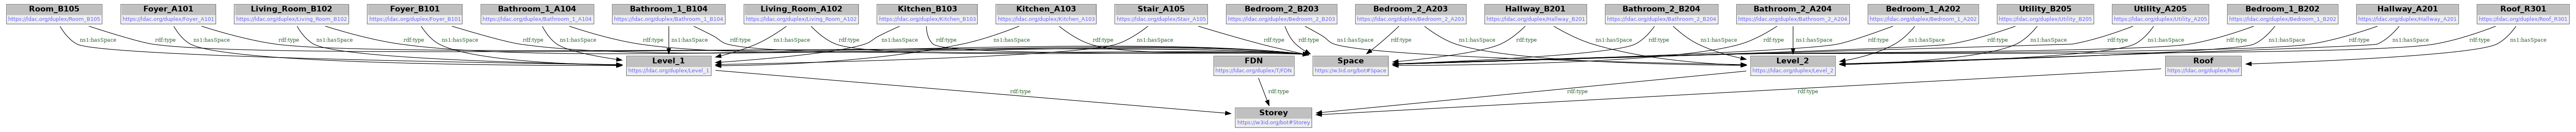

In [75]:
visualize(dg)

RDF Schema allows to specify classes and hierachies. These hierachies can be leverages for reasoning/inference. 

(rdflib.term.URIRef('http://example.org/schemas/vehicles#Van'), rdflib.term.URIRef('http://www.w3.org/1999/02/22-rdf-syntax-ns#type'), rdflib.term.URIRef('http://www.w3.org/2000/01/rdf-schema#Class'))
(rdflib.term.URIRef('http://example.org/schemas/vehicles#Van'), rdflib.term.URIRef('http://www.w3.org/2000/01/rdf-schema#subClassOf'), rdflib.term.URIRef('http://example.org/schemas/vehicles#MotorVehicle'))
(rdflib.term.URIRef('http://example.org/schemas/vehicles#MiniVan'), rdflib.term.URIRef('http://www.w3.org/2000/01/rdf-schema#subClassOf'), rdflib.term.URIRef('http://example.org/schemas/vehicles#PassengerVehicle'))
(rdflib.term.URIRef('http://example.org/schemas/vehicles#PassengerVehicle'), rdflib.term.URIRef('http://www.w3.org/2000/01/rdf-schema#subClassOf'), rdflib.term.URIRef('http://example.org/schemas/vehicles#MotorVehicle'))
(rdflib.term.URIRef('http://example.org/schemas/vehicles#MiniVan'), rdflib.term.URIRef('http://www.w3.org/2000/01/rdf-schema#subClassOf'), rdflib.term.URIRef

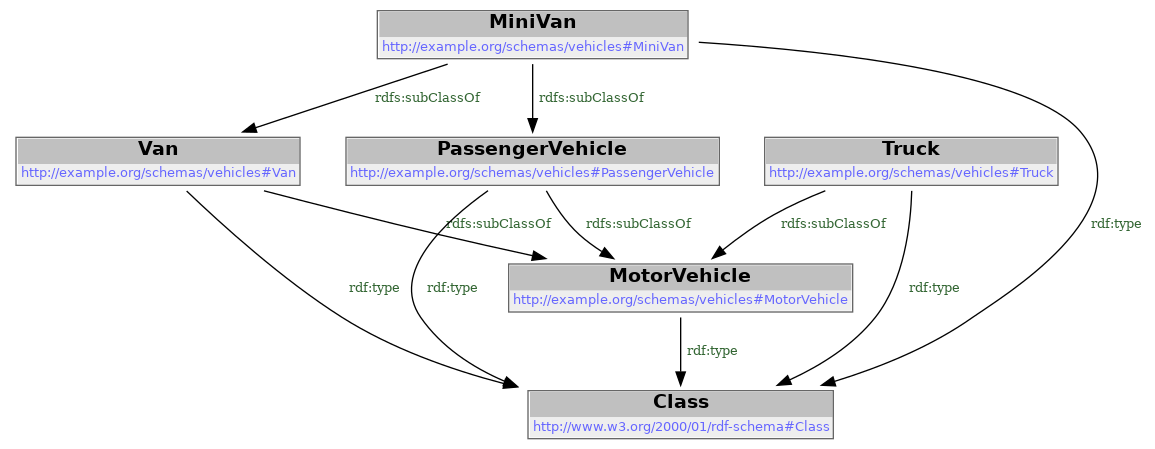

In [ ]:
g = Graph()
# Adapted from https://www.w3.org/TR/rdf-primer/
n3vehicledata = """\
@prefix ex: <http://example.org/schemas/vehicles#> .
@prefix rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#> .
@prefix rdfs: <http://www.w3.org/2000/01/rdf-schema#> .
ex:MotorVehicle       rdf:type          rdfs:Class .
ex:PassengerVehicle   rdf:type          rdfs:Class .
ex:Van                rdf:type          rdfs:Class .
ex:Truck              rdf:type          rdfs:Class .
ex:MiniVan            rdf:type          rdfs:Class .

ex:PassengerVehicle   rdfs:subClassOf   ex:MotorVehicle .
ex:Van                rdfs:subClassOf   ex:MotorVehicle .
ex:Truck              rdfs:subClassOf   ex:MotorVehicle .

ex:MiniVan            rdfs:subClassOf   ex:Van .
ex:MiniVan            rdfs:subClassOf   ex:PassengerVehicle .
"""


g.parse(data=n3vehicledata, format="n3")
#print all triples
for s, p, o in g:
   print((s, p, o))

# Visualize the graph for easy interpretation
visualize(g)

As rdfs:SubClassOf+ is transitive and reflexive, we can deduce facts which are not directly stated in the original triples.

# DBpedia

As discussed there are a number of public RDF data sources available. [DBpedia](https://wiki.dbpedia.org/) is a semantic version of Wikipedia. 

Let us query DBpedia to identify birthdays of architects and their buildngs(adapted from https://open.hpi.de/courses/knowledgegraphs2020).

In [28]:
from datetime import datetime
from SPARQLWrapper import SPARQLWrapper, JSON, XML, N3, RDF

In [29]:
sparql = SPARQLWrapper("http://dbpedia.org/sparql") #determine SPARQL endpoint

In [35]:
# retrieve architects born today (bif:curdate) and their builidngs 

sparql.setQuery("""
PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
PREFIX dbo: <http://dbpedia.org/ontology/>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
PREFIX dc:  <http://purl.org/dc/elements/1.1/>
PREFIX dct: <http://purl.org/dc/terms/>
PREFIX dbp: <http://dbpedia.org/property/>
PREFIX dbr: <http://dbpedia.org/resource/>
PREFIX dbc: <http://dbpedia.org/resource/Category:>

SELECT DISTINCT ?building, ?name, ?floors
WHERE
{
    ?building a dbo:Building .
    ?building dbo:floorCount ?floors .
    ?building rdfs:label ?name
    FILTER(LANGMATCHES(LANG(?name),'en'))
    FILTER (?floors >= 100)
}
ORDER BY ?floors
LIMIT 100 
""")

sparql.setReturnFormat(JSON)   # Return format is JSON
results = sparql.query().convert()   # execute SPARQL query and write result to "results"

In [ ]:
# retrieve architects born today (bif:curdate) and their builidngs 

sparql.setQuery("""
PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
PREFIX dbo: <http://dbpedia.org/ontology/>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
PREFIX dc:  <http://purl.org/dc/elements/1.1/>
PREFIX dct: <http://purl.org/dc/terms/>
PREFIX dbp: <http://dbpedia.org/property/>
PREFIX dbr: <http://dbpedia.org/resource/>
PREFIX dbc: <http://dbpedia.org/resource/Category:>

Select distinct ?birthdate ?architect ?name ?building ?location WHERE {
?architect rdf:type dbo:Architect ;
        dbo:birthDate ?birthdate ;
        rdfs:label ?name
     OPTIONAL {?building dbp:architect ?architect .}
 FILTER ((lang(?name)="en")&&(STRLEN(STR(?birthdate))>6)&&(SUBSTR(STR(?birthdate),6)=SUBSTR(STR(bif:curdate('')),6))) .
} ORDER BY ?birthdate
""")

sparql.setReturnFormat(JSON)   # Return format is JSON
results = sparql.query().convert()   # execute SPARQL query and write result to "results"

In [36]:
from pprint import pprint
pprint(results)

{'head': {'link': [], 'vars': ['building', 'name', 'floors']},
 'results': {'bindings': [{'building': {'type': 'uri',
                                        'value': 'http://dbpedia.org/resource/Al_Quds_Endowment_Tower'},
                           'floors': {'datatype': 'http://www.w3.org/2001/XMLSchema#positiveInteger',
                                      'type': 'typed-literal',
                                      'value': '100'},
                           'name': {'type': 'literal',
                                    'value': 'Al Quds Endowment Tower',
                                    'xml:lang': 'en'}},
                          {'building': {'type': 'uri',
                                        'value': 'http://dbpedia.org/resource/Eye_of_Spring_Trade_Center'},
                           'floors': {'datatype': 'http://www.w3.org/2001/XMLSchema#positiveInteger',
                                      'type': 'typed-literal',
                                      'value':